In [16]:
!pip install torch transformers datasets

In [17]:
!git config --global credential.helper store

In [18]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer, OPTForSequenceClassification
from transformers import AutoTokenizer, AlbertForSequenceClassification
from transformers import AutoTokenizer, GPT2ForSequenceClassification
import time
from sklearn.metrics import classification_report

In [19]:
dataset = load_dataset("./sentiment140.py", name="sentiment140")

In [5]:
from huggingface_hub import login
token = ""

In [6]:
model_name = "facebook/opt-125m"
num_labels = 2
tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)
model = OPTForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, token=token)

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def map_labels(example):
    example["sentiment"] = 0 if example["sentiment"] == 0 else 1
    return example

dataset = dataset.map(map_labels)

Map:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/251M [00:00<?, ?B/s]

Map:   0%|          | 0/498 [00:00<?, ? examples/s]

DOWNSAMPLING FOR TRAINING

In [8]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import pandas as pd

# Step 1: Convert to pandas
df = dataset['train'].to_pandas()

_, df_balanced = train_test_split(
    df,
    stratify=df["sentiment"],
    test_size=0.1,
    random_state=42
)

# train_dataset_small = Dataset.from_pandas(df_balanced)
# train_dataset_small = train_dataset_small.remove_columns(["__index_level_0__"])
print(len(df_balanced))

# Step 2: Stratified split (70/30)
df_train, df_temp = train_test_split(
    df_balanced,
    stratify=df_balanced["sentiment"],
    test_size=0.3,
    random_state=42
)

# Step 3: Split remaining 30% into val/test (50/50)
df_val, df_test = train_test_split(
    df_temp,
    stratify=df_temp["sentiment"],
    test_size=0.5,
    random_state=42
)

print(len(df_train))
print(len(df_val))
print(len(df_test))

# Step 4: Convert back to Hugging Face Datasets
train_dataset = Dataset.from_pandas(df_train).remove_columns(["__index_level_0__"])
val_dataset = Dataset.from_pandas(df_val).remove_columns(["__index_level_0__"])
test_dataset = Dataset.from_pandas(df_test).remove_columns(["__index_level_0__"])

# Step 5: Tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

# Step 6: Tokenize each split
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset   = val_dataset.map(tokenize_function, batched=True)
test_dataset  = test_dataset.map(tokenize_function, batched=True)

# Step 7: Set PyTorch format
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "sentiment"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "sentiment"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "sentiment"])

# (Optional) Wrap in a DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

# Print sizes to confirm
print(f"Train:     {len(dataset['train'])}")
print(f"Validation:{len(dataset['validation'])}")
print(f"Test:      {len(dataset['test'])}")

160000
112000
24000
24000


Map:   0%|          | 0/112000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Train:     112000
Validation:24000
Test:      24000


In [9]:
train_loader = DataLoader(dataset['train'], batch_size=16, shuffle=True)
val_loader = DataLoader(dataset['validation'], batch_size=16, shuffle=True)
test_loader = DataLoader(dataset['test'], batch_size=16)

In [10]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-5,
    weight_decay=0.01
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

OPTForSequenceClassification(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): La


Test Accuracy   : 0.4466
F1 Score (macro): 0.4008
F1 Score (weighted): 0.4008
Inference Time  : 139.21s

Classification Report:
              precision    recall  f1-score   support

    Negative       0.38      0.17      0.24     12000
    Positive       0.47      0.72      0.57     12000

    accuracy                           0.45     24000
   macro avg       0.42      0.45      0.40     24000
weighted avg       0.42      0.45      0.40     24000



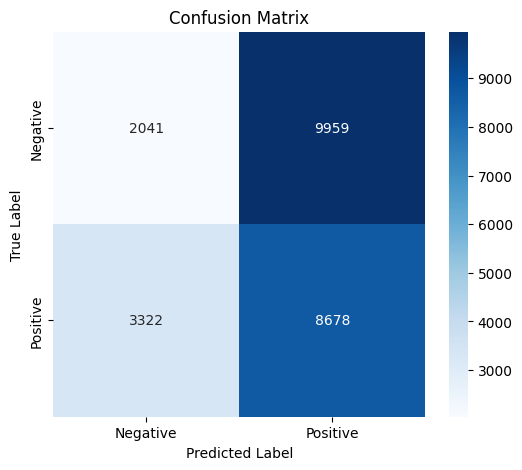

In [ ]:
import time
import torch
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

inference_start = time.time()

model.eval()
total_correct = 0
total_samples = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["sentiment"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
f1_macro = f1_score(all_labels, all_preds, average="macro")
f1_weighted = f1_score(all_labels, all_preds, average="weighted")
inference_time = time.time() - inference_start

print(f"\nTest Accuracy   : {accuracy:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"Inference Time  : {inference_time:.2f}s")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# LORA

In [ ]:
!pip install peft

In [ ]:
from peft import get_peft_model, LoraConfig, TaskType

lora_config = LoraConfig(
    r=16,                              # LoRA rank (8 or 16 are common)
    lora_alpha=32,                     # Scaling factor
    lora_dropout=0.1,                  # Dropout for LoRA layers
    bias="none",                       # Don't train bias terms
    task_type=TaskType.SEQ_CLS,        # Task type: sequence classification
    target_modules=["q_proj", "v_proj"]  # or ["c_attn"] for GPT-2
)


model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 591,360 || all params: 125,832,192 || trainable%: 0.4700


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

num_epochs = 6
best_val_f1 = 0.0
best_model_state = None

total_train_start = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["sentiment"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"\nEpoch {epoch+1}/{num_epochs} - Training Loss: {avg_loss:.4f}")

    # 🔍 Validation evaluation
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["sentiment"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Metrics
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"Validation Accuracy: {val_accuracy:.4f} - F1 (macro): {val_f1:.4f}")

    # 💾 Save best model (optional)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = model.state_dict()  # or `copy.deepcopy(model.state_dict())`

total_train_time = time.time() - total_train_start
print(f"\nTotal Training Time: {total_train_time:.2f}s")

# (Optional) Load best model
# model.load_state_dict(best_model_state)


Epoch 1/6 - Training Loss: 0.3725
Validation Accuracy: 0.8620 - F1 (macro): 0.8620

Epoch 2/6 - Training Loss: 0.3234
Validation Accuracy: 0.8677 - F1 (macro): 0.8677

Epoch 3/6 - Training Loss: 0.3047
Validation Accuracy: 0.8697 - F1 (macro): 0.8696

Epoch 4/6 - Training Loss: 0.2901
Validation Accuracy: 0.8719 - F1 (macro): 0.8719

Epoch 5/6 - Training Loss: 0.2774
Validation Accuracy: 0.8724 - F1 (macro): 0.8724

Epoch 6/6 - Training Loss: 0.2635
Validation Accuracy: 0.8737 - F1 (macro): 0.8737

Total Training Time: 9702.14s



Test Accuracy   : 0.8743
F1 Score (macro): 0.8743
F1 Score (weighted): 0.8743
Inference Time  : 150.16s

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.89      0.88     12000
    Positive       0.88      0.86      0.87     12000

    accuracy                           0.87     24000
   macro avg       0.87      0.87      0.87     24000
weighted avg       0.87      0.87      0.87     24000



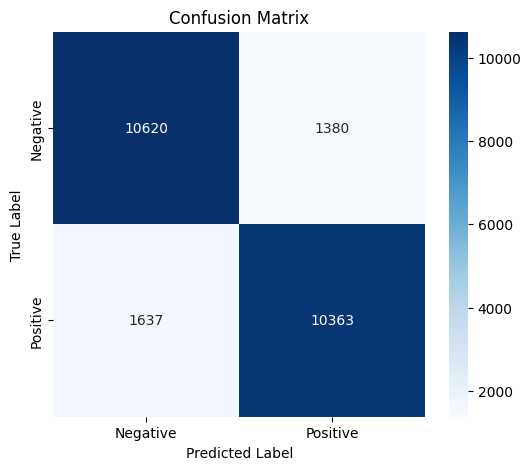

In [ ]:
import time
import torch
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

inference_start = time.time()

model.eval()
total_correct = 0
total_samples = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["sentiment"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
f1_macro = f1_score(all_labels, all_preds, average="macro")
f1_weighted = f1_score(all_labels, all_preds, average="weighted")
inference_time = time.time() - inference_start

print(f"\nTest Accuracy   : {accuracy:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"Inference Time  : {inference_time:.2f}s")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
if torch.cuda.is_available():
    max_memory = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
    print(f"Max GPU memory used: {max_memory:.2f} MB")

Max GPU memory used: 1773.43 MB


# BITFIT

In [11]:
model_name = "facebook/opt-125m"
num_labels = 2
tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)
model = OPTForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, token=token)

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
for name, param in model.named_parameters():
    if "bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [13]:
trainable = [name for name, param in model.named_parameters() if param.requires_grad]
print(f"Trainable parameters: {trainable}")

Trainable parameters: ['model.decoder.final_layer_norm.bias', 'model.decoder.layers.0.self_attn.k_proj.bias', 'model.decoder.layers.0.self_attn.v_proj.bias', 'model.decoder.layers.0.self_attn.q_proj.bias', 'model.decoder.layers.0.self_attn.out_proj.bias', 'model.decoder.layers.0.self_attn_layer_norm.bias', 'model.decoder.layers.0.fc1.bias', 'model.decoder.layers.0.fc2.bias', 'model.decoder.layers.0.final_layer_norm.bias', 'model.decoder.layers.1.self_attn.k_proj.bias', 'model.decoder.layers.1.self_attn.v_proj.bias', 'model.decoder.layers.1.self_attn.q_proj.bias', 'model.decoder.layers.1.self_attn.out_proj.bias', 'model.decoder.layers.1.self_attn_layer_norm.bias', 'model.decoder.layers.1.fc1.bias', 'model.decoder.layers.1.fc2.bias', 'model.decoder.layers.1.final_layer_norm.bias', 'model.decoder.layers.2.self_attn.k_proj.bias', 'model.decoder.layers.2.self_attn.v_proj.bias', 'model.decoder.layers.2.self_attn.q_proj.bias', 'model.decoder.layers.2.self_attn.out_proj.bias', 'model.decoder.l

In [14]:
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-5
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

OPTForSequenceClassification(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): La

In [23]:
from sklearn.metrics import accuracy_score, f1_score

num_epochs = 3
best_val_f1 = 0.0
best_model_state = None

total_train_start = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["sentiment"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"\nEpoch {epoch+1}/{num_epochs} - Training Loss: {avg_loss:.4f}")

    # 🔍 Validation evaluation
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["sentiment"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Metrics
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"Validation Accuracy: {val_accuracy:.4f} - F1 (macro): {val_f1:.4f}")

    # 💾 Save best model (optional)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = model.state_dict()  # or `copy.deepcopy(model.state_dict())`

total_train_time = time.time() - total_train_start
print(f"\nTotal Training Time: {total_train_time:.2f}s")

# (Optional) Load best model
# model.load_state_dict(best_model_state)


Epoch 1/3 - Training Loss: 0.4179
Validation Accuracy: 0.8411 - F1 (macro): 0.8411

Epoch 2/3 - Training Loss: 0.3693
Validation Accuracy: 0.8495 - F1 (macro): 0.8495

Epoch 3/3 - Training Loss: 0.3572
Validation Accuracy: 0.8526 - F1 (macro): 0.8526




Test Accuracy   : 0.8567
F1 Score (macro): 0.8567
F1 Score (weighted): 0.8567
Inference Time  : 144.18s

Classification Report:
              precision    recall  f1-score   support

    Negative       0.85      0.87      0.86     12000
    Positive       0.87      0.85      0.86     12000

    accuracy                           0.86     24000
   macro avg       0.86      0.86      0.86     24000
weighted avg       0.86      0.86      0.86     24000



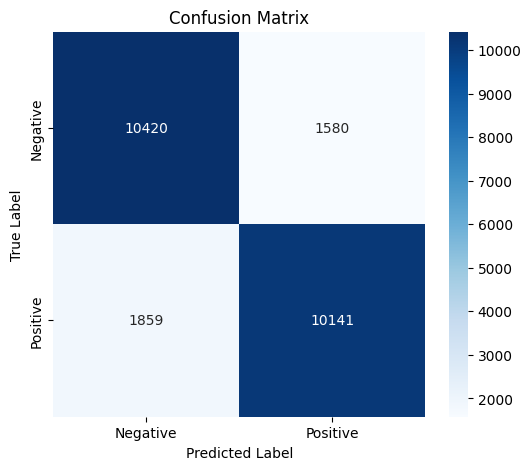

In [20]:
import time
import torch
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

inference_start = time.time()

model.eval()
total_correct = 0
total_samples = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["sentiment"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
f1_macro = f1_score(all_labels, all_preds, average="macro")
f1_weighted = f1_score(all_labels, all_preds, average="weighted")
inference_time = time.time() - inference_start

print(f"\nTest Accuracy   : {accuracy:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"Inference Time  : {inference_time:.2f}s")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [21]:
if torch.cuda.is_available():
    max_memory = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
    print(f"Max GPU memory used: {max_memory:.2f} MB")

Max GPU memory used: 2067.55 MB
